In [15]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import IsolationForest


sns.set(style="whitegrid")


from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import (classification_report, confusion_matrix, 
                             precision_score, recall_score, f1_score, roc_auc_score, roc_curve)

from sklearn.manifold import TSNE



In [16]:
df = pd.read_csv('creditcard.csv')
df.head()



,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [17]:
print("Shape:", df.shape)
print("Missing values:\n", df.isnull().sum())
print("Class distribution:\n", df['Class'].value_counts())


Shape: (284807, 31)
Missing values:
 Time      0
V1        0
V2        0
V3        0
V4        0
V5        0
V6        0
V7        0
V8        0
V9        0
V10       0
V11       0
V12       0
V13       0
V14       0
V15       0
V16       0
V17       0
V18       0
V19       0
V20       0
V21       0
V22       0
V23       0
V24       0
V25       0
V26       0
V27       0
V28       0
Amount    0
Class     0
dtype: int64
Class distribution:
 Class
0    284315
1       492
Name: count, dtype: int64


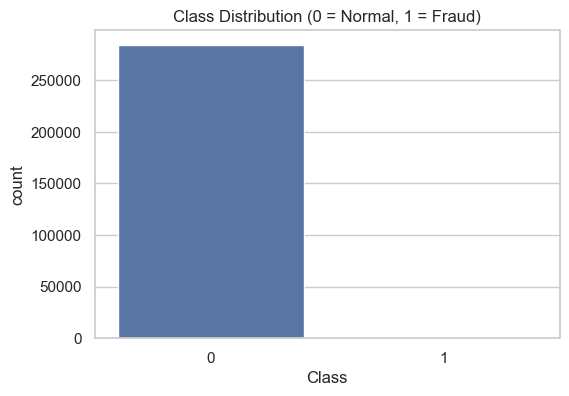

In [18]:
plt.figure(figsize=(6,4))
sns.countplot(x='Class', data=df)
plt.title("Class Distribution (0 = Normal, 1 = Fraud)")
plt.show()


In [ ]:
# Drop Time, keep relevant features
X = df.drop(columns=['Time', 'Class'])
y = df['Class']

model = IsolationForest(n_estimators=100, contamination=0.0017, random_state=42)
y_pred = model.fit_predict(X)

# Convert prediction (-1: anomaly, 1: normal) to (1: fraud, 0: normal)
y_pred = [1 if x == -1 else 0 for x in y_pred]


In [ ]:
print(confusion_matrix(y, y_pred))
print(classification_report(y, y_pred))


[[283969    346]
 [   353    139]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    284315
           1       0.29      0.28      0.28       492

    accuracy                           1.00    284807
   macro avg       0.64      0.64      0.64    284807
weighted avg       1.00      1.00      1.00    284807



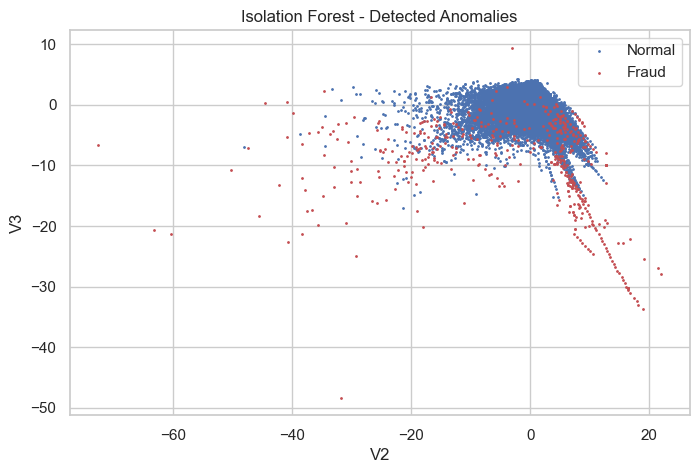

In [ ]:
df['Predicted'] = y_pred

frauds = df[df['Predicted'] == 1]
normals = df[df['Predicted'] == 0]

plt.figure(figsize=(8,5))
plt.scatter(normals['V2'], normals['V3'], s=1, label='Normal')
plt.scatter(frauds['V2'], frauds['V3'], s=1, label='Fraud', color='r')
plt.xlabel('V2')
plt.ylabel('V3')
plt.legend()
plt.title("Isolation Forest - Detected Anomalies")
plt.show()


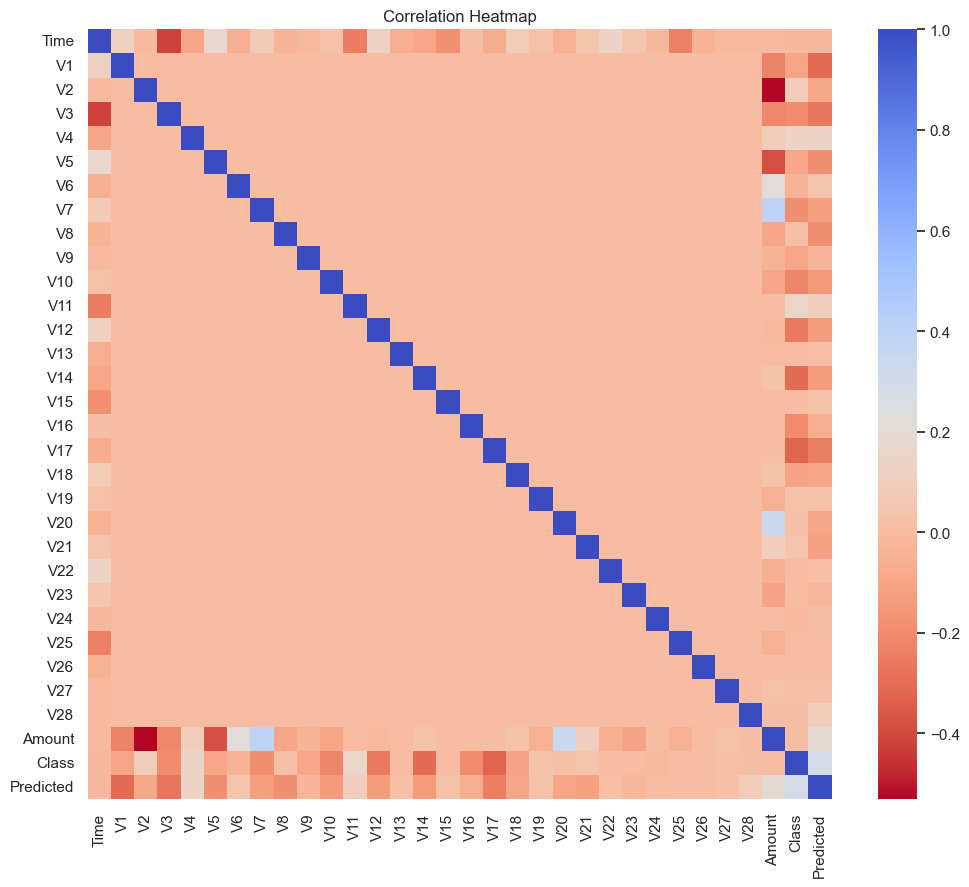

Top 10 correlations with Class:
 Class        1.000000
Predicted    0.283323
V11          0.154876
V4           0.133447
V2           0.091289
V21          0.040413
V19          0.034783
V20          0.020090
V8           0.019875
V27          0.017580
Name: Class, dtype: float64


In [ ]:
corr = df.corr()
plt.figure(figsize=(12,10))
sns.heatmap(corr, cmap='coolwarm_r', annot=False)
plt.title("Correlation Heatmap")
plt.show()


corr_target = corr['Class'].sort_values(ascending=False)
print("Top 10 correlations with Class:\n", corr_target.head(10))


AUC Score: 0.9635


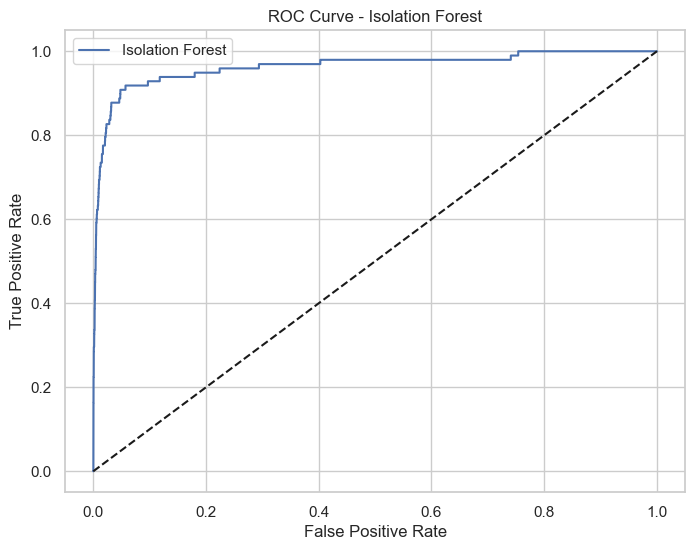

In [ ]:

X = df.drop(columns=['Class', 'Time'])
y = df['Class']  # 1 = Fraud, 0 = Legit

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=1)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


model = IsolationForest(contamination=0.001, random_state=1)
model.fit(X_train_scaled)
y_scores = -model.decision_function(X_test_scaled)  


fpr, tpr, thresholds = roc_curve(y_test, y_scores)
auc = roc_auc_score(y_test, y_scores)
print(f"AUC Score: {auc:.4f}")

plt.figure(figsize=(8,6))
plt.plot(fpr, tpr, label='Isolation Forest')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - Isolation Forest')
plt.legend()
plt.show()